In [1]:
import torch.nn as nn
import torch

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, n_outputs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1
        self.n_outputs = n_outputs
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        # self.fcs = [nn.Linear(self.hidden_size, self.output_size).to(device) for i in range(self.n_outputs)]
        self.fc1 = nn.Linear(self.hidden_size, self.output_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.fc3 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        # print(input_seq.shape)
        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(device)
        # print(input_seq.size())
        # input(batch_size, seq_len, input_size)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0))
        preds = []
        pred1, pred2, pred3 = self.fc1(output), self.fc2(output), self.fc3(output)
        pred1, pred2, pred3 = pred1[:, -1, :], pred2[:, -1, :], pred3[:, -1, :]

        # pred = torch.cat([pred1, pred2], dim=0)
        pred = torch.stack([pred1, pred2, pred3], dim=0)
        # print(pred.shape)

        return pred

In [3]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 6
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(r'E:\VS Code\COVID-19\csse_covid_19_data\csse_covid_19_time_series\time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/27/22,9/28/22,9/29/22,9/30/22,10/1/22,10/2/22,10/3/22,10/4/22,10/5/22,10/6/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,198750,198876,199067,199188,199310,199386,199545,199690,199845,199994
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,332066,332129,332173,332221,332263,332285,332290,332337,332372,332410
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,270654,270662,270668,270673,270676,270679,270682,270690,270693,270697
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,46147,46227,46227,46227,46227,46227,46227,46227,46227,46275
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,103131,103131


In [5]:
df = df.iloc[:, 4:]

In [6]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,9/27/22,9/28/22,9/29/22,9/30/22,10/1/22,10/2/22,10/3/22,10/4/22,10/5/22,10/6/22
0,0,0,0,0,0,0,0,0,0,0,...,198750,198876,199067,199188,199310,199386,199545,199690,199845,199994
1,0,0,0,0,0,0,0,0,0,0,...,332066,332129,332173,332221,332263,332285,332290,332337,332372,332410
2,0,0,0,0,0,0,0,0,0,0,...,270654,270662,270668,270673,270676,270679,270682,270690,270693,270697
3,0,0,0,0,0,0,0,0,0,0,...,46147,46227,46227,46227,46227,46227,46227,46227,46227,46275
4,0,0,0,0,0,0,0,0,0,0,...,103131,103131,103131,103131,103131,103131,103131,103131,103131,103131


In [7]:
df.isnull().sum().sum()

0

In [8]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     557
2020-01-23     657
2020-01-24     944
2020-01-25    1437
2020-01-26    2120
dtype: int64

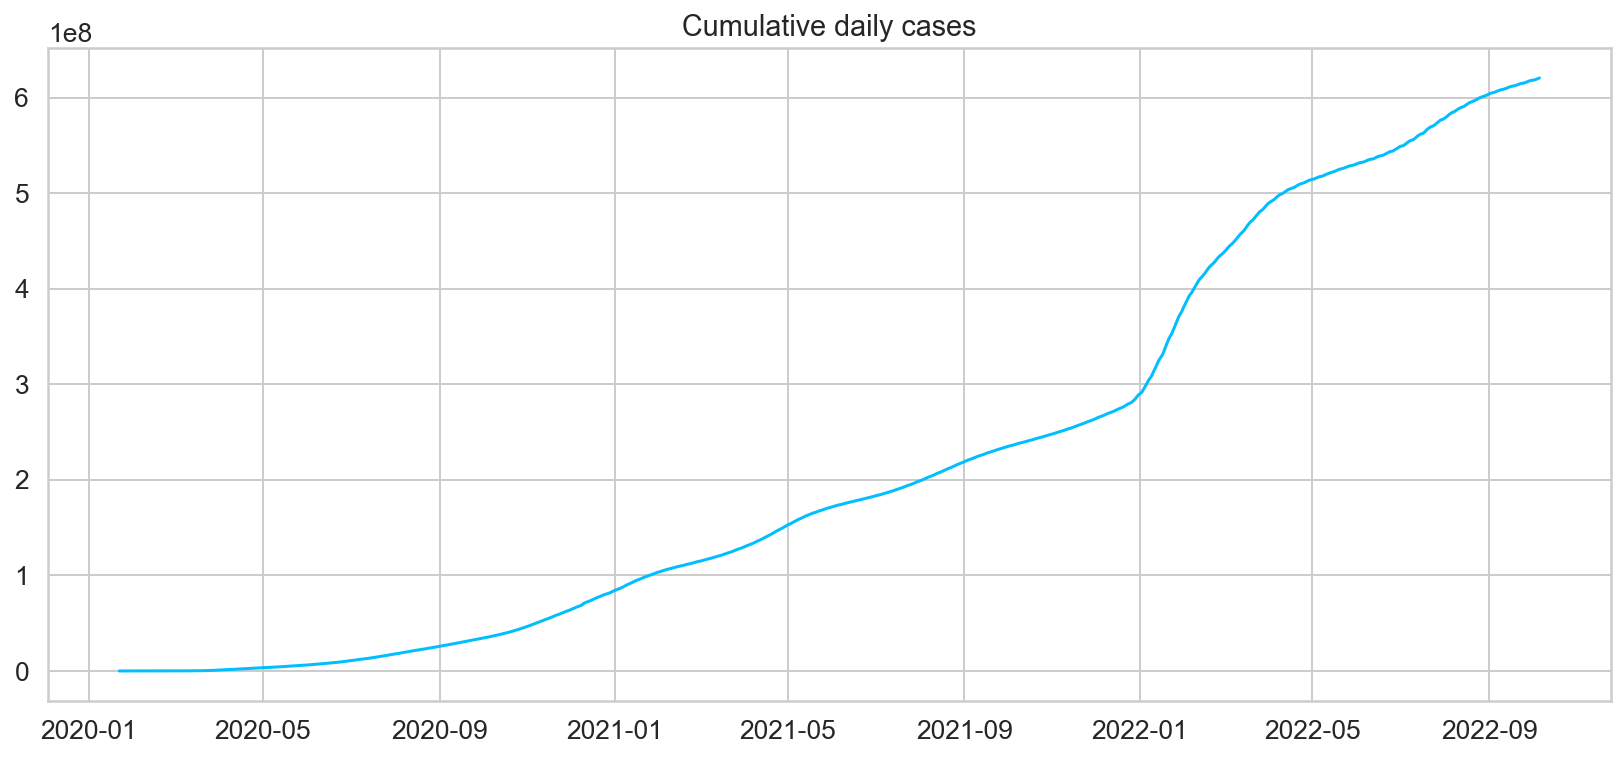

In [9]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [10]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    557
2020-01-23    100
2020-01-24    287
2020-01-25    493
2020-01-26    683
dtype: int64

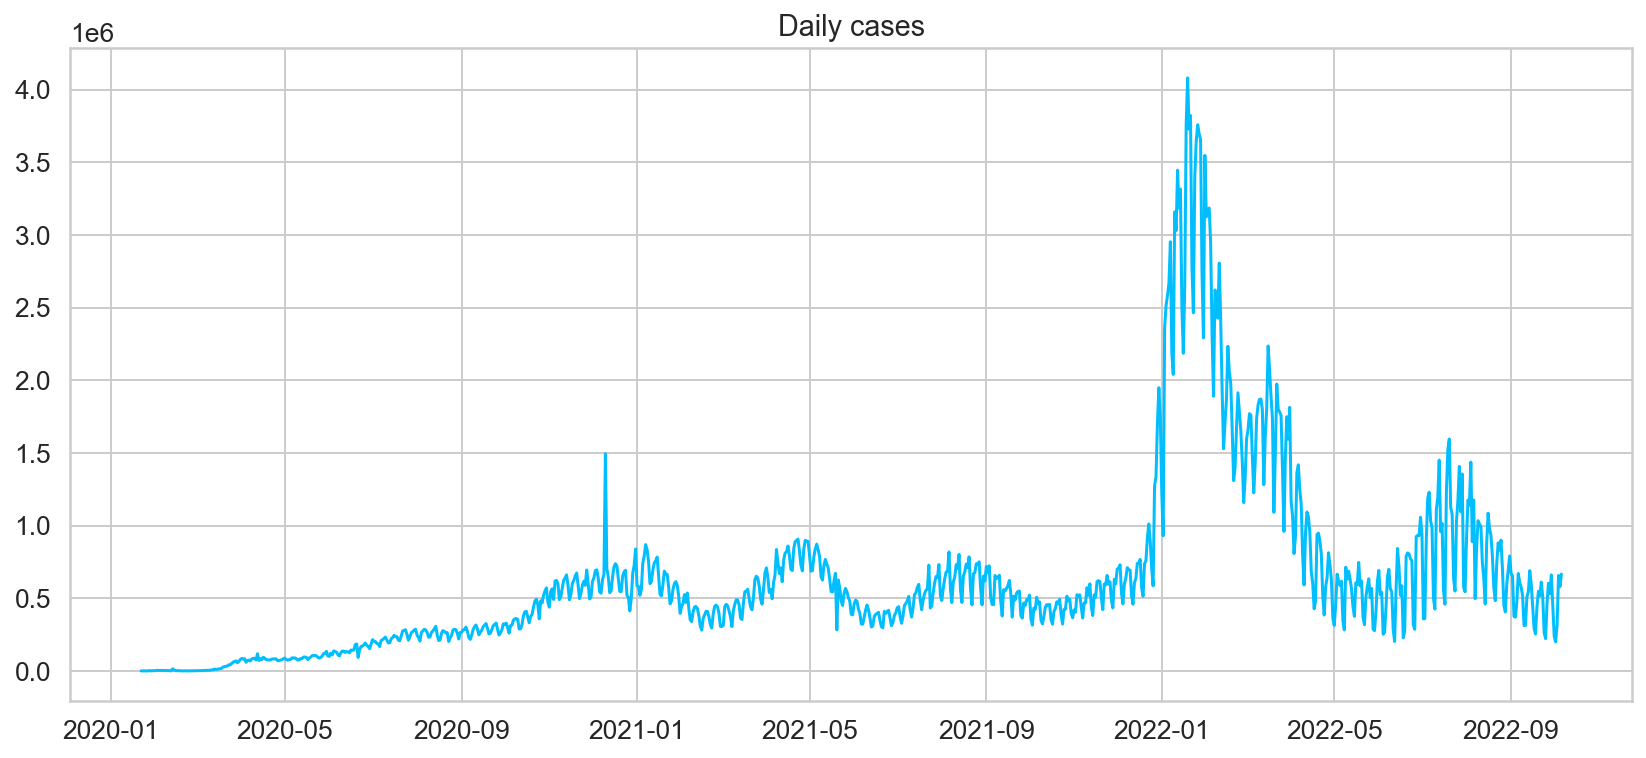

In [11]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [12]:
daily_cases.shape

(989,)

In [13]:
test_data_size = 155

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(834,)

In [14]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [15]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 7
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [16]:
X_train.shape

torch.Size([826, 7, 1])

In [17]:
X_train[:2]

tensor([[[1.1195e-04],
         [0.0000e+00],
         [4.5811e-05],
         [9.6276e-05],
         [1.4282e-04],
         [1.7369e-04],
         [6.2493e-04]],

        [[0.0000e+00],
         [4.5811e-05],
         [9.6276e-05],
         [1.4282e-04],
         [1.7369e-04],
         [6.2493e-04],
         [1.1979e-04]]])

In [18]:
y_train.shape

torch.Size([826, 1])

In [19]:
y_train[:2]

tensor([[0.0001],
        [0.0005]])

In [20]:
train_data[:10]

array([[1.11954129e-04],
       [0.00000000e+00],
       [4.58105516e-05],
       [9.62756512e-05],
       [1.42821131e-04],
       [1.73688134e-04],
       [6.24934316e-04],
       [1.19793367e-04],
       [4.82113184e-04],
       [3.89512176e-04]])

In [21]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [22]:
def train_model(
      model, 
      train_data, 
      train_labels, 
      test_data=None, 
      test_labels=None
    ):
    loss_fn = torch.nn.MSELoss(reduction='sum')

    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 100

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()

            if t % 10 == 0:  
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')

        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    return model.eval(), train_hist, test_hist

In [23]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 37.35835266113281 test loss: 4.100551128387451
Epoch 10 train loss: 18.82456398010254 test loss: 1.3983179330825806
Epoch 20 train loss: 14.760458946228027 test loss: 2.6812312602996826
Epoch 30 train loss: 13.03364086151123 test loss: 6.455130577087402


KeyboardInterrupt: 

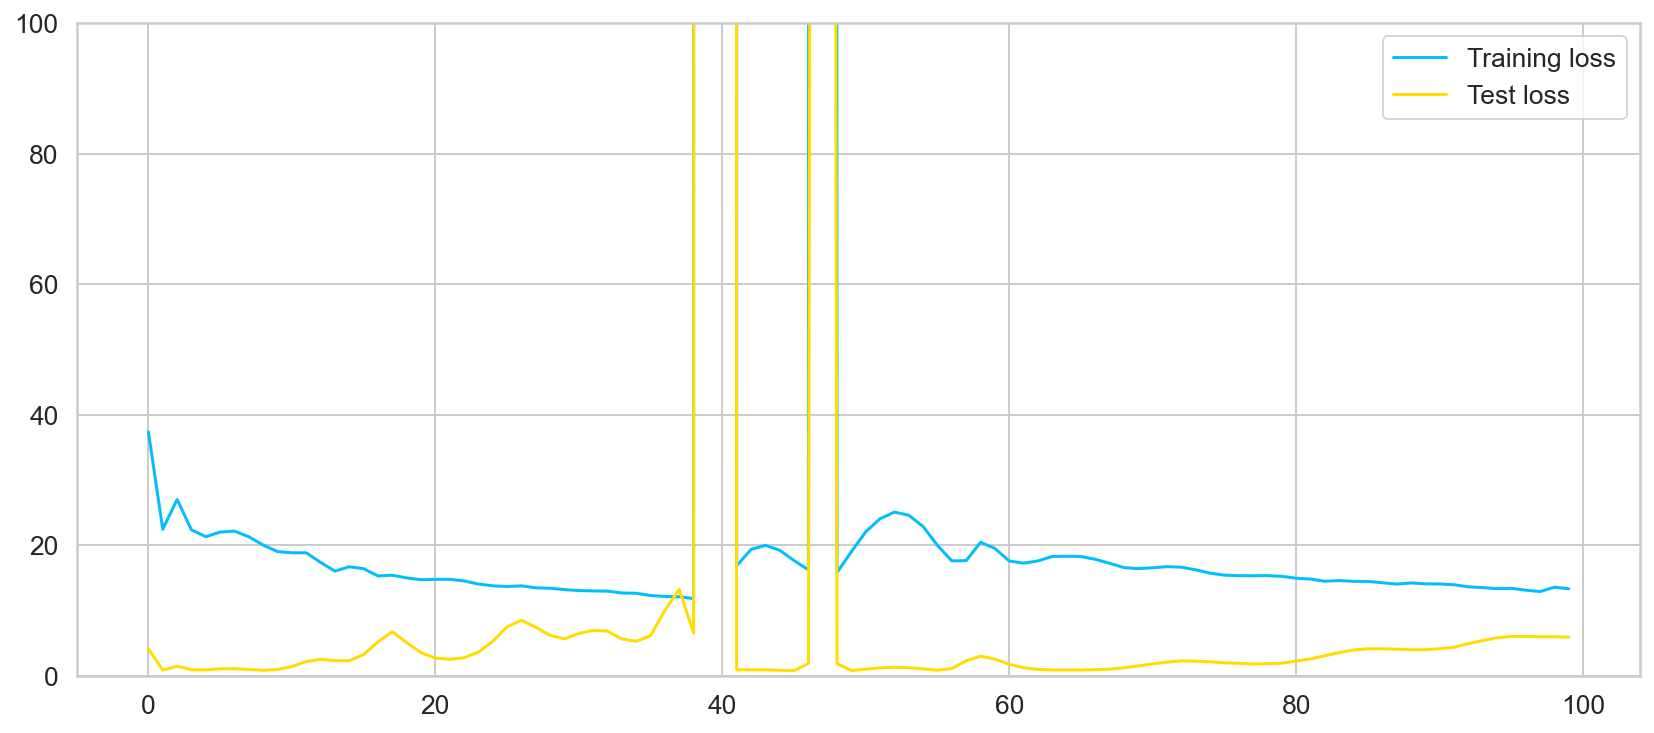

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 100))
plt.legend()

In [ ]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq
                   ).view(1, seq_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

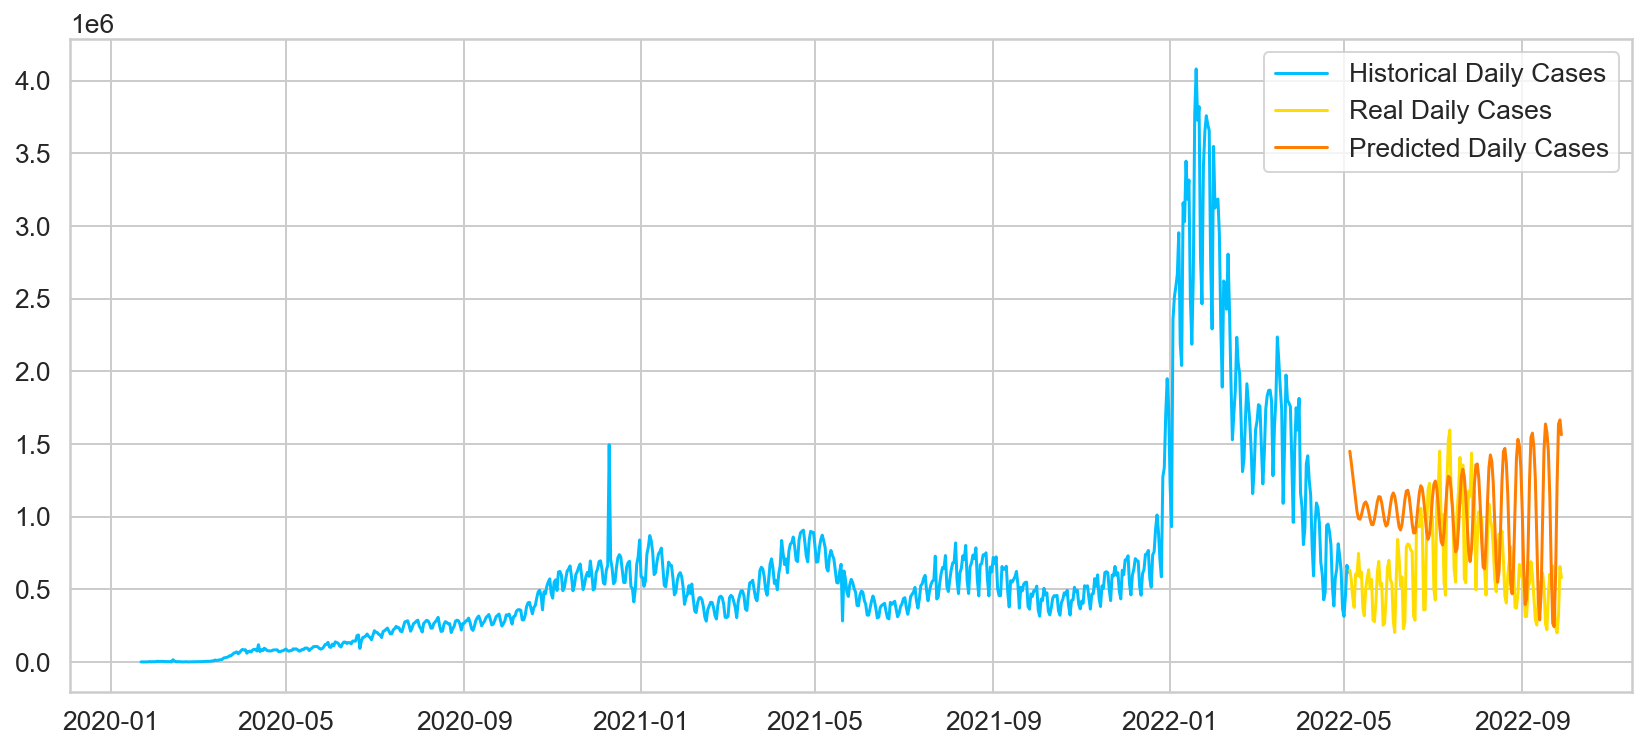

In [ ]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases')

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases')

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases')

plt.legend();

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(989, 1)

In [ ]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 28.75185203552246
Epoch 10 train loss: 16.00760841369629
Epoch 20 train loss: 14.023649215698242
Epoch 30 train loss: 12.835872650146484
Epoch 40 train loss: 11.332722663879395
Epoch 50 train loss: 10553.6025390625
Epoch 60 train loss: 598.8355712890625
Epoch 70 train loss: 136.20639038085938
Epoch 80 train loss: 22.722614288330078
Epoch 90 train loss: 22.425247192382812


In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
daily_cases.index[-1]

Timestamp('2022-10-06 00:00:00')

C:\Users\96212\AppData\Local\Temp\ipykernel_16000\17706630.py:1: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_index = pd.date_range(


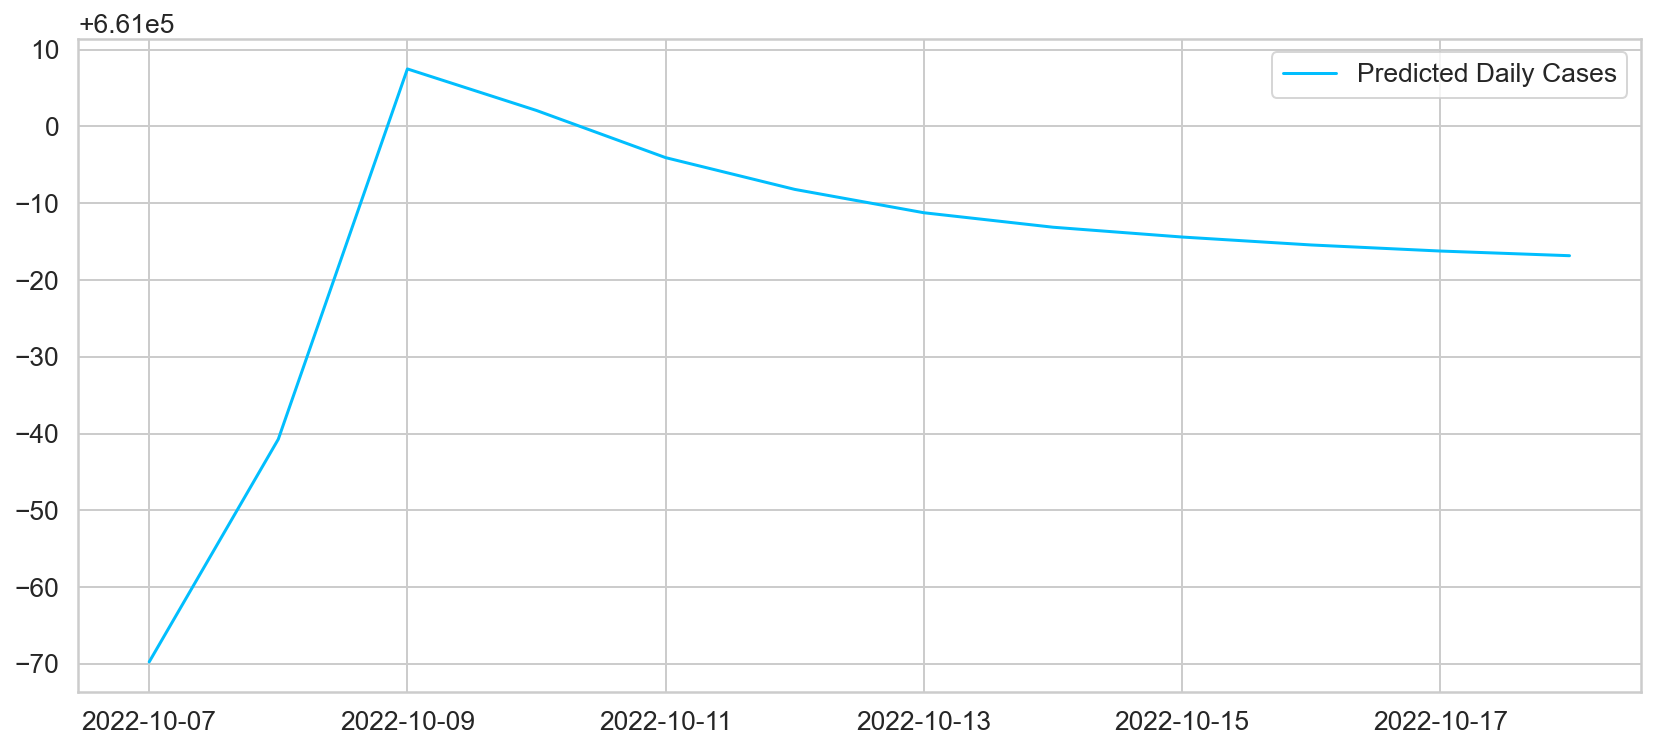

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

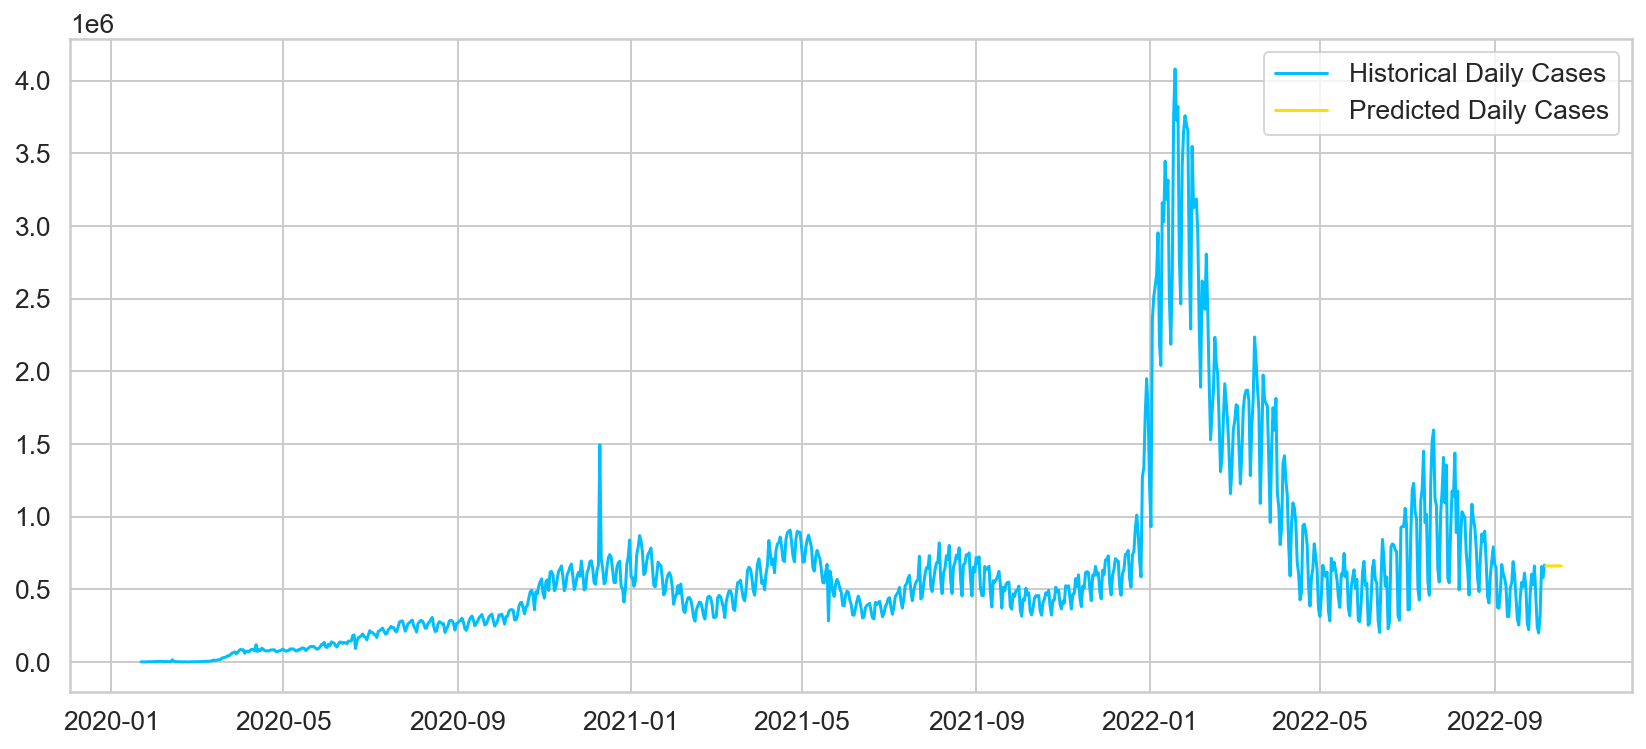

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

In [ ]:
predicted_cases

2022-10-07    660930.247058
2022-10-08    660959.261523
2022-10-09    661007.497312
2022-10-10    661002.083712
2022-10-11    660995.940187
2022-10-12    660991.803953
2022-10-13    660988.762605
2022-10-14    660986.876969
2022-10-15    660985.599602
2022-10-16    660984.565544
2022-10-17    660983.774793
2022-10-18    660983.166523
Freq: D, dtype: float64

# 111

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
x=np.arange(0,150.1,0.1).tolist()

In [4]:
#print(x.shape)
sin_y=np.sin(x)
cos_y=np.cos(x)
tan_y=np.tan(x)
y_set=np.array([sin_y,cos_y,cos_y])

In [5]:
#print(y_set[:,0])
x_test=[]
y_test=[]

In [6]:
for i in range(1000):
    '''
    建立训练集，x为sin_y、cos_y、tan_y构成的(50,3)的数组，y为下一个（比如x为i列到i+50列，y就是第i+51列）(1，3)的数组
    '''
    x_test.append(y_set[:,i:i+50].T.tolist())
    y_test.append(y_set[:,i+51].tolist())

In [7]:
print(np.array(x_test))
print(np.array(x_test).shape)
print(np.array(y_test).shape)

[[[ 0.          1.          1.        ]
  [ 0.09983342  0.99500417  0.99500417]
  [ 0.19866933  0.98006658  0.98006658]
  ...
  [-0.99992326 -0.01238866 -0.01238866]
  [-0.99616461  0.08749898  0.08749898]
  [-0.98245261  0.18651237  0.18651237]]

 [[ 0.09983342  0.99500417  0.99500417]
  [ 0.19866933  0.98006658  0.98006658]
  [ 0.29552021  0.95533649  0.95533649]
  ...
  [-0.99616461  0.08749898  0.08749898]
  [-0.98245261  0.18651237  0.18651237]
  [-0.95892427  0.28366219  0.28366219]]

 [[ 0.19866933  0.98006658  0.98006658]
  [ 0.29552021  0.95533649  0.95533649]
  [ 0.38941834  0.92106099  0.92106099]
  ...
  [-0.98245261  0.18651237  0.18651237]
  [-0.95892427  0.28366219  0.28366219]
  [-0.92581468  0.37797774  0.37797774]]

 ...

 [[-0.73858223  0.67416341  0.67416341]
  [-0.66758835  0.74453058  0.74453058]
  [-0.58992416  0.80745866  0.80745866]
  ...
  [-0.66496162 -0.74687753 -0.74687753]
  [-0.73620292 -0.67676086 -0.67676086]
  [-0.80008832 -0.59988222 -0.59988222]]

 [

In [8]:
np.random.seed(168)
np.random.shuffle(x_test)
np.random.seed(168)
np.random.shuffle(y_test)
x=torch.tensor(x_test).to(device)
y=torch.tensor(y_test).to(device)

In [9]:
epoch=10#训练10代
input_size=3#词向量的维度，即是(50,3)中的3
hidden_size=16#隐藏层维度
num_layers=7#层数
output_size=3#输出的维度，即是(1,3)中的3
batch_size=32#一次训练的样本数

In [10]:
class MyDataset():
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)

In [11]:
class LSTM(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 30, 64)
        pred = self.linear(output)  # (5, 30, 1)
        #print(pred)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [12]:
net=LSTM()
# net = torch.load('model_LSTM_test.pth')
net = net.to(device)

In [13]:
criterion=nn.MSELoss()#均方误差计算损失率
optimizer=torch.optim.Adam(net.parameters(),lr=1e-2)
n=0

In [14]:
for i in range(epoch):
    for j in range(int(len(y)/batch_size)):
        train_X=x[j*batch_size:(j+1)*batch_size,:,:]#切分一个batch
        train_Y=y[j*batch_size:(j+1)*batch_size,:]
        var_x=torch.tensor(train_X,dtype=torch.float32)#,device=device
        var_y=torch.tensor(train_Y,dtype=torch.float32)#,device=device
        out = net(var_x)#输出

        optimizer.zero_grad()
        loss=criterion(out,var_y)
        loss.backward()
        optimizer.step()
        if i%1==0:
            print('Epoch: {:4}, Loss: {:.5f}'.format(i, loss.item()))
    torch.save(net, 'model_LSTM_test.pth')

C:\Users\96212\AppData\Local\Temp\ipykernel_10104\112587001.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_x=torch.tensor(train_X,dtype=torch.float32)#,device=device
C:\Users\96212\AppData\Local\Temp\ipykernel_10104\112587001.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var_y=torch.tensor(train_Y,dtype=torch.float32)#,device=device


Epoch:    0, Loss: 0.60499
Epoch:    0, Loss: 0.49578
Epoch:    0, Loss: 0.55212
Epoch:    0, Loss: 0.47954
Epoch:    0, Loss: 0.50137
Epoch:    0, Loss: 0.50551
Epoch:    0, Loss: 0.50311
Epoch:    0, Loss: 0.52689
Epoch:    0, Loss: 0.54187
Epoch:    0, Loss: 0.51772
Epoch:    0, Loss: 0.49323
Epoch:    0, Loss: 0.51110
Epoch:    0, Loss: 0.49262
Epoch:    0, Loss: 0.48773
Epoch:    0, Loss: 0.46225
Epoch:    0, Loss: 0.49904
Epoch:    0, Loss: 0.54188
Epoch:    0, Loss: 0.51105
Epoch:    0, Loss: 0.47288
Epoch:    0, Loss: 0.51098
Epoch:    0, Loss: 0.43014
Epoch:    0, Loss: 0.45896
Epoch:    0, Loss: 0.37191
Epoch:    0, Loss: 0.39669
Epoch:    0, Loss: 0.34193
Epoch:    0, Loss: 0.28541
Epoch:    0, Loss: 0.26627
Epoch:    0, Loss: 0.26857
Epoch:    0, Loss: 0.30783
Epoch:    0, Loss: 0.31907
Epoch:    0, Loss: 0.26431
Epoch:    1, Loss: 0.24441
Epoch:    1, Loss: 0.25295
Epoch:    1, Loss: 0.21365
Epoch:    1, Loss: 0.23594
Epoch:    1, Loss: 0.18758
Epoch:    1, Loss: 0.18219
E